In [68]:
from PIL import Image
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import scipy
import skimage
import skimage.color
from PIL import Image
import cv2
%matplotlib inline
from pypardiso import spsolve


In [72]:
#Define dataset directory and pandas dataframe
depth_dir = "C:/Users/anthc/Documents/Penn Spring 2020/RoboFly/train/"
orig = "C:/Users/anthc/Documents/Penn Spring 2020/RoboFly/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000102.png"
img1 = "C:/Users/anthc/Documents/Penn Spring 2020/RoboFly/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02/0000000102.png"
img2 = "C:/Users/anthc/Documents/Penn Spring 2020/RoboFly/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_03/0000000102.png"

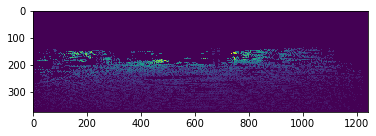

In [73]:
img1 = np.array(Image.open(img1))
img2 = np.array(Image.open(img2))
imshow(img1 + img2)

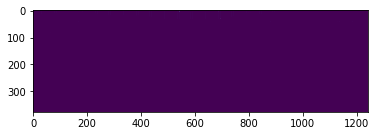

In [47]:
#https://github.com/mrharicot/monodepth/blob/master/utils/evaluation_utils.py#L29

width_to_focal = dict()
width_to_focal[1242] = 721.5377
width_to_focal[1241] = 718.856
width_to_focal[1224] = 707.0493
width_to_focal[1238] = 718.3351

gt_disp = cv2.imread(img, -1)
gt_disp = gt_disp.astype(np.float32) / 256
        
height, width = gt_disp.shape
mask = gt_disp > 0

gt_depth = width_to_focal[width] * 0.54 / (gt_disp + (1.0 - mask))
    
imshow(gt_depth)

In [7]:
#https://github.com/soulslicer/kitti_depthmap
def fill_depth_colorization(imgRgb=None, imgDepthInput=None, alpha=1):
	imgIsNoise = imgDepthInput == 0
	maxImgAbsDepth = np.max(imgDepthInput)
	imgDepth = imgDepthInput / maxImgAbsDepth
	imgDepth[imgDepth > 1] = 1
	(H, W) = imgDepth.shape
	numPix = H * W
	indsM = np.arange(numPix).reshape((W, H)).transpose()
	knownValMask = (imgIsNoise == False).astype(int)
	grayImg = skimage.color.rgb2gray(imgRgb)
	winRad = 1
	len_ = 0
	absImgNdx = 0
	len_window = (2 * winRad + 1) ** 2
	len_zeros = numPix * len_window

	cols = np.zeros(len_zeros) - 1
	rows = np.zeros(len_zeros) - 1
	vals = np.zeros(len_zeros) - 1
	gvals = np.zeros(len_window) - 1

	for j in range(W):
		for i in range(H):
			nWin = 0
			for ii in range(max(0, i - winRad), min(i + winRad + 1, H)):
				for jj in range(max(0, j - winRad), min(j + winRad + 1, W)):
					if ii == i and jj == j:
						continue

					rows[len_] = absImgNdx
					cols[len_] = indsM[ii, jj]
					gvals[nWin] = grayImg[ii, jj]

					len_ = len_ + 1
					nWin = nWin + 1

			curVal = grayImg[i, j]
			gvals[nWin] = curVal
			c_var = np.mean((gvals[:nWin + 1] - np.mean(gvals[:nWin+ 1])) ** 2)

			csig = c_var * 0.6
			mgv = np.min((gvals[:nWin] - curVal) ** 2)
			if csig < -mgv / np.log(0.01):
				csig = -mgv / np.log(0.01)

			if csig < 2e-06:
				csig = 2e-06

			gvals[:nWin] = np.exp(-(gvals[:nWin] - curVal) ** 2 / csig)
			gvals[:nWin] = gvals[:nWin] / sum(gvals[:nWin])
			vals[len_ - nWin:len_] = -gvals[:nWin]

	  		# Now the self-reference (along the diagonal).
			rows[len_] = absImgNdx
			cols[len_] = absImgNdx
			vals[len_] = 1  # sum(gvals(1:nWin))

			len_ = len_ + 1
			absImgNdx = absImgNdx + 1

	vals = vals[:len_]
	cols = cols[:len_]
	rows = rows[:len_]
	A = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

	rows = np.arange(0, numPix)
	cols = np.arange(0, numPix)
	vals = (knownValMask * alpha).transpose().reshape(numPix)
	G = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

	A = A + G
	b = np.multiply(vals.reshape(numPix), imgDepth.flatten('F'))

	#print ('Solving system..')

	new_vals = spsolve(A, b)
	new_vals = np.reshape(new_vals, (H, W), 'F')

	#print ('Done.')

	denoisedDepthImg = new_vals * maxImgAbsDepth
    
	output = denoisedDepthImg.reshape((H, W)).astype('float32')

	output = np.multiply(output, (1-knownValMask)) + imgDepthInput
    
	return output

In [8]:
def depth_read(filename):
    # loads depth map D from png file
    # and returns it as a numpy array,
    # for details see readme.txt

    depth_png = np.array(Image.open(filename), dtype=int)
    # make sure we have a proper 16bit depth map here.. not 8bit!
    assert(np.max(depth_png) > 255)

    depth = depth_png.astype(np.float) / 256.
    depth[depth_png == 0] = -1.
    return depth

In [9]:
depth_map = depth_read(img)
print(np.max(depth_map))

82.90234375


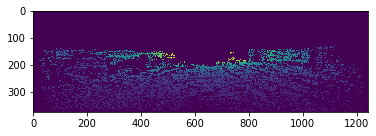

In [10]:
imshow(depth_map)

In [11]:
x = fill_depth_colorization(imgRgb=orig, imgDepthInput=depth_map, alpha=1)

AttributeError: 'str' object has no attribute 'ndim'

In [12]:
imshow(x)

NameError: name 'x' is not defined

In [65]:
nulls = np.sum(depth_map == -1)
print(nulls / (depth_map.shape[0] * depth_map.shape[1]))

0.8115104669887279


In [66]:
depth_map[0]

array([-1., -1., -1., ..., -1., -1., -1.])